# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gamma

In [2]:
# Necessary for visualization
!pip install nilearn --quiet
from nilearn import plotting, datasets

     |████████████████████████████████| 4.9 MB 6.3 MB/s 


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [4]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [5]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [6]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [7]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [8]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [9]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
                                name=regions[0].tolist(),
                                network=regions[1],
                                myelin=regions[2].astype(np.float),
                            )

regions_df = pd.DataFrame(regions)
regions_df

0        1        2    ...           357           358           359
0     R_V1    R_MST     R_V6  ...          L_PI       L_a32pr         L_p24
1  Visual1  Visual2  Visual2  ...  Cingulo-Oper  Cingulo-Oper  Cingulo-Oper
2    2.209  2.05561   2.1498  ...       1.74335       1.73082       1.65968

[3 rows x 360 columns]

In [10]:
#AV 
#regions_df.iloc[0,:].nunique()
regions_df.nunique(axis=1)
#list(regions_df.iloc[1,:].values_counts())
#list(map(set,regions_df.values)) # works
#pd.DataFrame()
# print(list(map(set,regions_df.iloc[:,0:-1].values))[1])
# print(len(list(map(set,regions_df.iloc[:,0:-1].values))[1]))
# print(len(list(map(set,regions_df.iloc[:,0:-1].values))[0]))
# print(len(list(map(set,regions_df.iloc[:,0:-1].values))[2]))
#regions_df.values[2]

regions_df['num_uniq'] = regions_df.stack().groupby(level=0).nunique() # counts no. of unique items in a row & puts counts in a new column
#regions_df[:,-1]
#regions_df.iloc[:,0:-1] # prints df without last column


We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [11]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)



# print(pd.DataFrame( atlas['coords']) )

# print(len(atlas['labels_L']))
# print(len(atlas['coords'])) # coords for each region
# print(len(atlas['labels_R']))
#pd.DataFrame( atlas['coords'] )

# Helper functions


## Data loading

In [12]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [13]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

In [14]:
# # resting state fMRI

# timeseries = load_timeseries(subject=0, name="GAMBLING", runs=0)
# print(timeseries.shape)  # n_parcel x n_timepoint

In [15]:
# # The time series for 1 run for 1 subject
# timeseries_df= pd.DataFrame(timeseries)
# timeseries_df # n_parcel x n_timepoint

In [16]:
# pd.DataFrame( load_timeseries(subject=0, name="GAMBLING", runs=0) [:, condition_frames(load_evs( 0 , 'GAMBLING' , 'loss_event'))[0]  ] .mean( axis=1)  )

If you want to import as csv

In [17]:
# loss_event_df.to_csv( 'x_data.csv')

In [18]:
loss_event_array=[] 
for sub in subjects:
    for i in [0,1]:
        # for each subject for each run, we will take the activity time only and then take it's average, mean of the activity at that certain time

        loss_event_array.append( load_timeseries(subject=sub, name="GAMBLING", runs=i)[:, condition_frames(load_evs( sub , 'GAMBLING' , 'loss_event'))[i]  ].mean( axis=1) )

loss_event_df= pd.DataFrame( loss_event_array )

In [19]:
loss_event_df.head() # subjects x Parcels

0          1          2    ...        357        358        359
0  26.795921  15.524843  -2.774477  ...  -5.763304   7.013681  -3.761302
1  11.282349  -0.334630 -16.693467  ... -16.303535  27.705765  15.769339
2   9.896344   6.345774   0.166171  ...   7.195051  -0.795447 -10.407310
3  -6.670886   2.258308 -10.693320  ...   1.941225  -9.682309   0.649209
4  43.683088  15.511073  21.860343  ...  -2.103995   6.361860  -0.757349

[5 rows x 360 columns]

In [20]:
#loss_event_df

In [21]:
win_event_array=[] 
for sub in subjects:
    for i in [0,1]:
         win_event_array.append( load_timeseries(subject=sub, name="GAMBLING", runs=i)[:, condition_frames(load_evs( sub , 'GAMBLING' , 'win_event'))[i]  ].mean( axis=1))

win_event_df= pd.DataFrame( win_event_array )

In [22]:
win_event_df.head() # subjects x Parcels

0          1          2    ...        357        358        359
0 -37.167771  -1.252490 -38.172733  ...  -7.142074 -30.203344 -44.519045
1   8.811813   1.639298  -6.292574  ...   8.159501   5.183444  13.936482
2 -14.191738   4.465241  -8.241624  ...   0.685205 -31.030216 -28.035822
3   1.047257   3.247308  -9.142070  ... -10.190025   2.043226 -20.489541
4  -0.538553  10.653729  -6.528016  ...   1.044518  -4.555883   9.971061

[5 rows x 360 columns]

## Correlation Contrast

In [23]:
contrast = win_event_df - loss_event_df

In [24]:
# describtion= contrast.describe()
# describtion
contrast.drop(135 , axis=0,inplace=True)

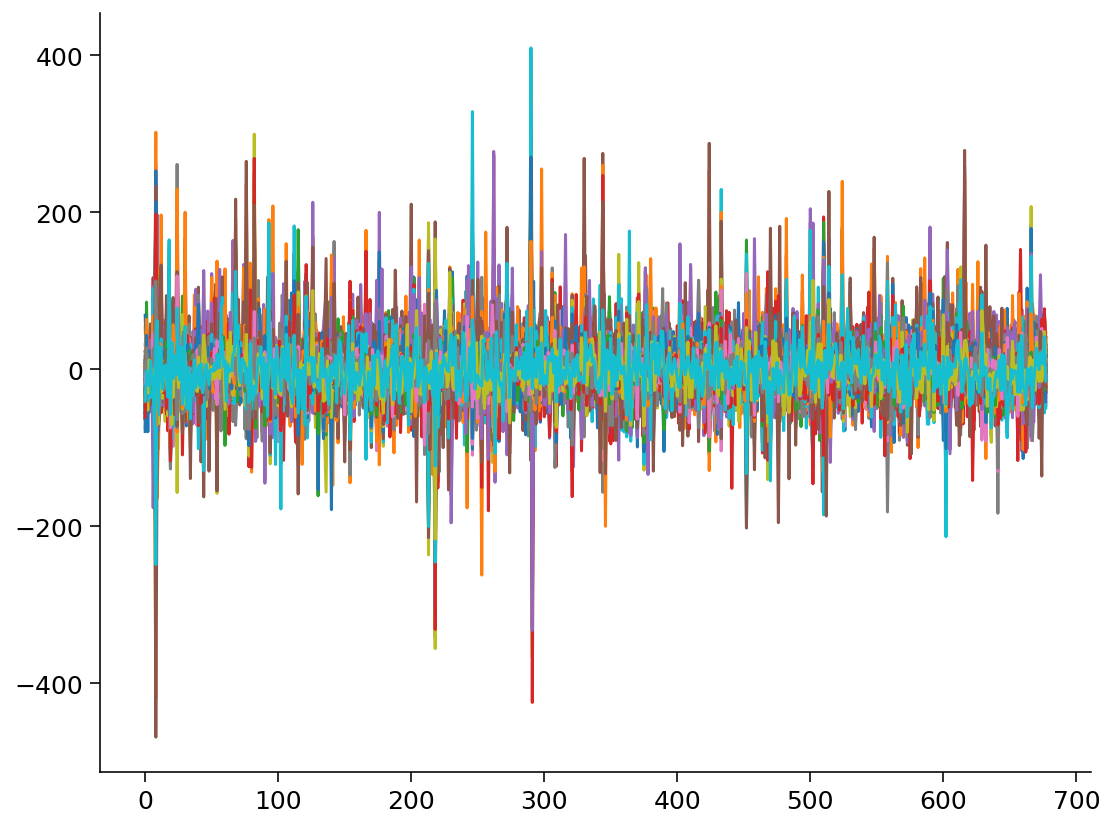

In [25]:
plt.plot(contrast)
plt.show()

# taking mean over all subject for RIO

In [26]:
describtion= contrast.mean(axis=0)#.describe()
describtion

0     -4.594539
1     -1.489228
2     -0.728332
3     -3.679878
4     -1.136725
         ...   
355    2.104020
356   -0.816476
357   -2.567814
358   -4.122327
359   -1.279900
Length: 360, dtype: float64

# Highest/Lowest 10 parcel activity

In [27]:
# highest_10= np.argsort(describtion.max())[::-1][:10].to_numpy()
highest_10= np.argsort(describtion)[::-1][:10].to_numpy()

highest_10

array([271, 164, 245, 344,  64, 270, 244,  91, 267,  87])

In [28]:
# lowest_10= np.argsort(describtion.min())[:10].to_numpy()
lowest_10= np.argsort(describtion)[:10].to_numpy()

lowest_10

array([201, 290, 186, 107, 178, 287, 291,  85,   0,  88])

In [29]:
roi=[]

for i in range (10):
    roi.append( lowest_10 [i])
for i in range (10):    
    roi.append(highest_10[i]) 
#roi

In [30]:
#contrast[roi]

In [31]:
#contrast[roi].describe()

In [32]:
# find the outliers
#contrast.iloc[135,:].max()

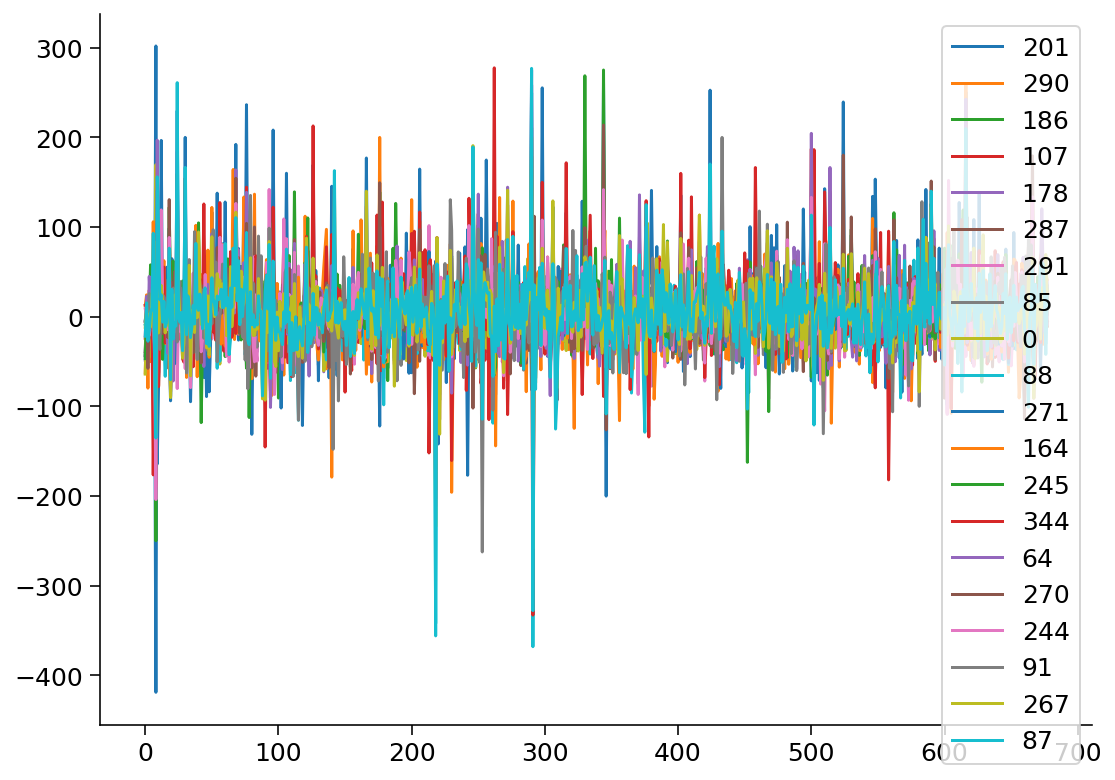

In [33]:
contrast[roi].plot()

# WORK ON THIS

In [34]:
#contrast[roi] 

In [35]:
#contrast[roi].mean(axis=0)

In [36]:
# dropping unwanted col
regions_df.drop(columns='num_uniq' , inplace=True)

In [37]:
# seing the regions each parcel represents
roi_regions= regions_df.iloc[:,roi]
roi_regions

201           290      186  ...           91            267           87 
0    L_PIT         L_AVI     L_V8  ...         R_13l         L_10v         R_10v
1  Visual2  Frontopariet  Visual2  ...  Frontopariet  Posterior-Mu  Posterior-Mu
2  1.81313       1.79861  1.89331  ...       1.71313       1.66138       1.62027

[3 rows x 20 columns]

In [38]:
#roi_regions.iloc[1,:]

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

In [39]:
# # re-naiming the roi areas
# cor_df.set_index(roi_regions.iloc[1,:])

In [40]:
# win_event_df[roi].head()

In [41]:
# win_event_df[roi].T.set_index(roi_regions.iloc[1,:]).head()

# Win_Event Corr matrix

In [42]:
# cor_df = np.zeros( (N_SUBJECTS*2, len(roi), len(roi) ) )

# cor_df = pd.DataFrame( np.corrcoef( win_event_df[roi].T.set_index(roi_regions.iloc[1,:])  ) )

# fig,ax= plt.subplots()
# ax.imshow( cor_df , interpolation="none", cmap="bwr", vmin=-1, vmax=1, )
# ax.set_xticks(np.arange(20))
# ax.set_yticks(np.arange(20))
# # ... and label them with the respective list entries

# ax.set_yticklabels(roi_regions.iloc[1,:].to_numpy() )

# ax.set_xticklabels(roi_regions.iloc[1,:].to_numpy())
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# plt.show()


# Loss_Event corr matrix

In [43]:
# cor_df = np.zeros( (N_SUBJECTS*2, len(roi), len(roi) ) )

# cor_df = pd.DataFrame( np.corrcoef( loss_event_df[roi].T.set_index(roi_regions.iloc[1,:])  ) )


# fig,ax= plt.subplots()
# ax.imshow( cor_df , interpolation="none", cmap="bwr", vmin=-1, vmax=1, )
# ax.set_xticks(np.arange(20))
# ax.set_yticks(np.arange(20))
# # ... and label them with the respective list entries

# ax.set_yticklabels(roi_regions.iloc[1,:].to_numpy() )

# ax.set_xticklabels(roi_regions.iloc[1,:].to_numpy())
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")
# plt.show()

# Correlation matrix for winning and Losing

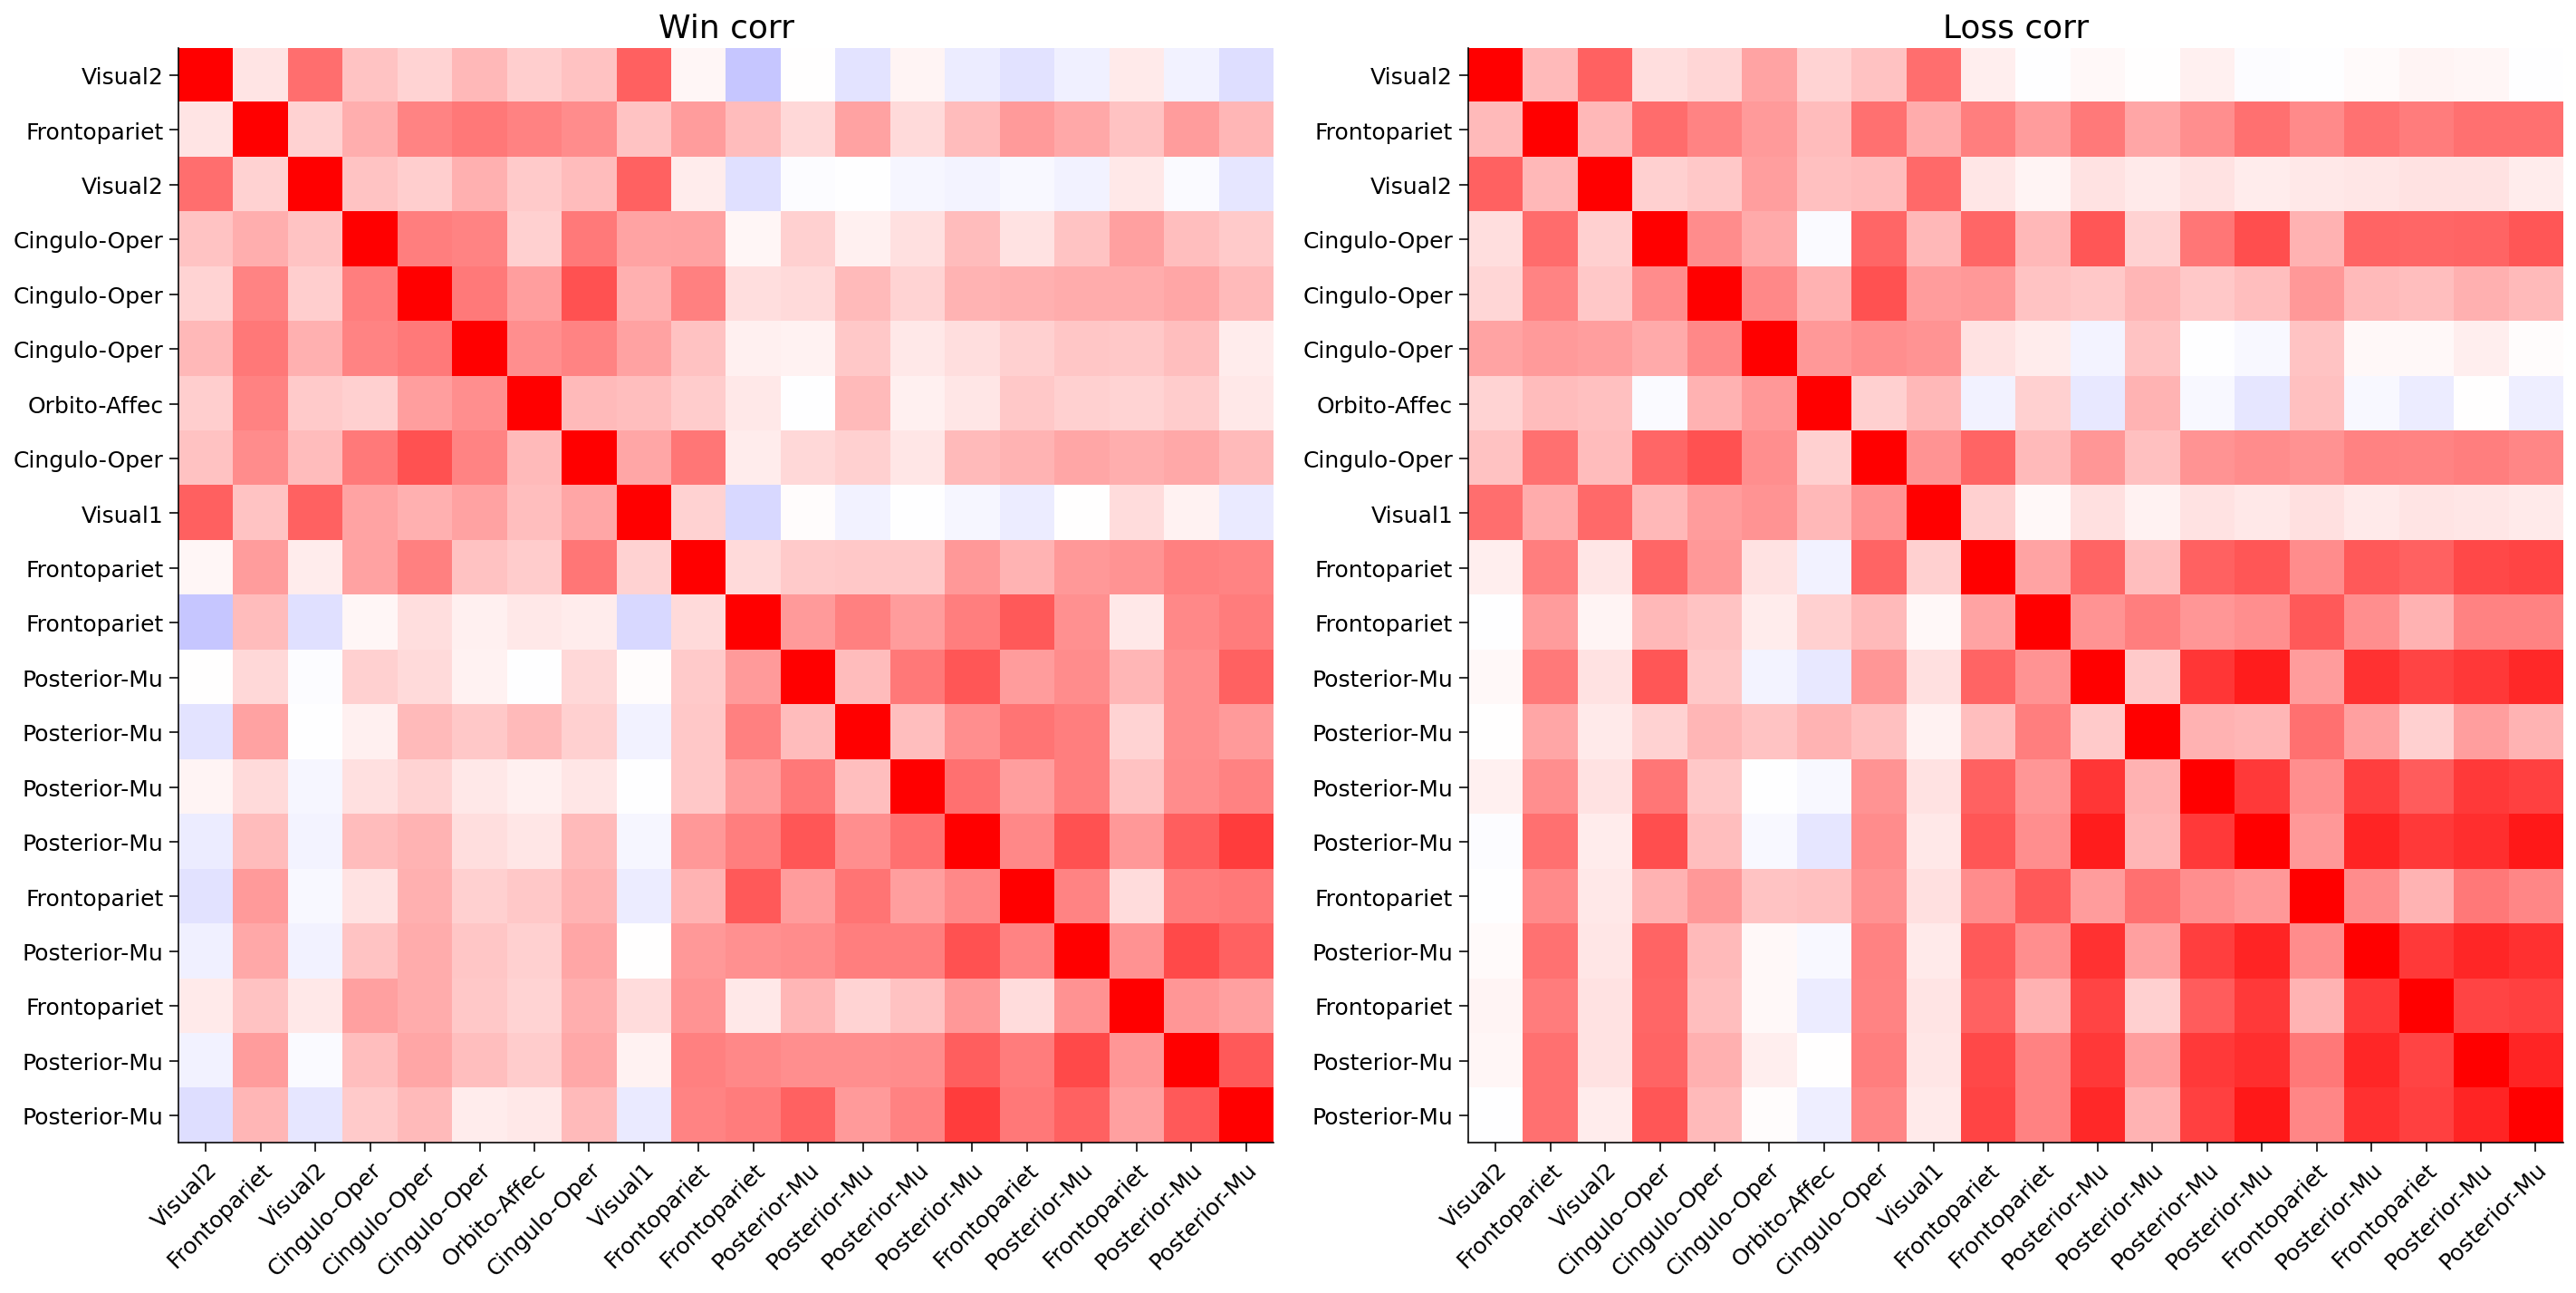

In [44]:
cor_win = np.zeros( (N_SUBJECTS*2, len(roi), len(roi) ) )

cor_win = pd.DataFrame( np.corrcoef( win_event_df[roi].T.set_index(roi_regions.iloc[1,:])  ) )

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20, 20 ) )
ax1.imshow( cor_win , interpolation="none", cmap="bwr", vmin=-1, vmax=1, )
ax1.set_xticks(np.arange(20))
ax1.set_yticks(np.arange(20))

ax1.set_yticklabels(roi_regions.iloc[1,:].to_numpy() )



cor_loss = np.zeros( (N_SUBJECTS*2, len(roi), len(roi) ) )

cor_loss = pd.DataFrame( np.corrcoef( loss_event_df[roi].T.set_index(roi_regions.iloc[1,:])  ) )

ax2.imshow( cor_loss , interpolation="none", cmap="bwr", vmin=-1, vmax=1, )
ax2.set_xticks(np.arange(20))
ax2.set_yticks(np.arange(20))

ax2.set_yticklabels(roi_regions.iloc[1,:].to_numpy() )


ax1.set_xticklabels(roi_regions.iloc[1,:].to_numpy())
ax1.set_title('Win corr')
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_xticklabels(roi_regions.iloc[1,:].to_numpy())
ax2.set_title('Loss corr')
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

# Using GLM models

First lets prepare our data

In [45]:
#len( win_event_df)==len(loss_event_df)

In [46]:
# adding win condition to the winning data
win_event_df['cond']=pd.Series(np.ones((678,) , dtype=int) )
win_event_df.head()

0          1          2  ...        358        359  cond
0 -37.167771  -1.252490 -38.172733  ... -30.203344 -44.519045     1
1   8.811813   1.639298  -6.292574  ...   5.183444  13.936482     1
2 -14.191738   4.465241  -8.241624  ... -31.030216 -28.035822     1
3   1.047257   3.247308  -9.142070  ...   2.043226 -20.489541     1
4  -0.538553  10.653729  -6.528016  ...  -4.555883   9.971061     1

[5 rows x 361 columns]

In [47]:
# adding loss condition to the loss data
loss_event_df['cond']=pd.Series(np.zeros((678,) , dtype=int) )
loss_event_df.head()

0          1          2  ...        358        359  cond
0  26.795921  15.524843  -2.774477  ...   7.013681  -3.761302     0
1  11.282349  -0.334630 -16.693467  ...  27.705765  15.769339     0
2   9.896344   6.345774   0.166171  ...  -0.795447 -10.407310     0
3  -6.670886   2.258308 -10.693320  ...  -9.682309   0.649209     0
4  43.683088  15.511073  21.860343  ...   6.361860  -0.757349     0

[5 rows x 361 columns]

combining the loss and win data

In [48]:
loss_event_df.append( win_event_df)

0          1          2  ...        358        359  cond
0    26.795921  15.524843  -2.774477  ...   7.013681  -3.761302     0
1    11.282349  -0.334630 -16.693467  ...  27.705765  15.769339     0
2     9.896344   6.345774   0.166171  ...  -0.795447 -10.407310     0
3    -6.670886   2.258308 -10.693320  ...  -9.682309   0.649209     0
4    43.683088  15.511073  21.860343  ...   6.361860  -0.757349     0
..         ...        ...        ...  ...        ...        ...   ...
673  43.738883  12.550227   5.579412  ...  20.557727  18.342060     1
674  20.841216  25.928503   6.133737  ...   0.726026  -2.135336     1
675  35.270351  15.837252   2.569363  ...   2.085494  -9.286502     1
676  20.959854  16.007968  16.285759  ...  36.796260  23.041174     1
677  13.737633  -2.108410 -10.986537  ...  18.004580 -11.066868     1

[1356 rows x 361 columns]

specifying the features and labels

In [49]:
X= loss_event_df.append( win_event_df).iloc[:, :-1]
X

0          1          2    ...        357        358        359
0    26.795921  15.524843  -2.774477  ...  -5.763304   7.013681  -3.761302
1    11.282349  -0.334630 -16.693467  ... -16.303535  27.705765  15.769339
2     9.896344   6.345774   0.166171  ...   7.195051  -0.795447 -10.407310
3    -6.670886   2.258308 -10.693320  ...   1.941225  -9.682309   0.649209
4    43.683088  15.511073  21.860343  ...  -2.103995   6.361860  -0.757349
..         ...        ...        ...  ...        ...        ...        ...
673  43.738883  12.550227   5.579412  ...  10.555094  20.557727  18.342060
674  20.841216  25.928503   6.133737  ...  -3.171931   0.726026  -2.135336
675  35.270351  15.837252   2.569363  ... -12.166527   2.085494  -9.286502
676  20.959854  16.007968  16.285759  ...  -6.372344  36.796260  23.041174
677  13.737633  -2.108410 -10.986537  ...   1.374471  18.004580 -11.066868

[1356 rows x 360 columns]

In [50]:
y= loss_event_df.append( win_event_df).iloc[:,-1]
y

0      0
1      0
2      0
3      0
4      0
      ..
673    1
674    1
675    1
676    1
677    1
Name: cond, Length: 1356, dtype: int64

# Applying classification models based on the activity of brain

## First we will start by using the whole data for all the parcels

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [52]:
x_train , x_test , y_train , y_test = train_test_split(X , y)

In [53]:
rf= RandomForestClassifier()
rf.fit(x_train , y_train)
rf.score(x_test,y_test)

0.7286135693215339

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
lr= LogisticRegressionCV( cv= 20  )
lr.fit(x_train , y_train)

In [55]:
# score of the Logistic Regression model with CV= 10
lr.score(x_test,y_test)

0.8200589970501475

In [56]:
# score of the rigde classifier model with Cross Validation = 10
from sklearn.linear_model import RidgeClassifierCV
rc= RidgeClassifierCV( cv= 10)
rc.fit(x_train , y_train)

RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]), class_weight=None, cv=10,
                  fit_intercept=True, normalize=False, scoring=None,
                  store_cv_values=False)

In [57]:
rc.score(x_test,y_test)

0.7935103244837758

Creating a classification report for the highest accuracy model => Logistic Regression

In [58]:
from sklearn.metrics import classification_report 
predictions= lr.predict( x_test)
print( classification_report( predictions , y_test ) )

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       176
           1       0.80      0.84      0.82       163

    accuracy                           0.82       339
   macro avg       0.82      0.82      0.82       339
weighted avg       0.82      0.82      0.82       339



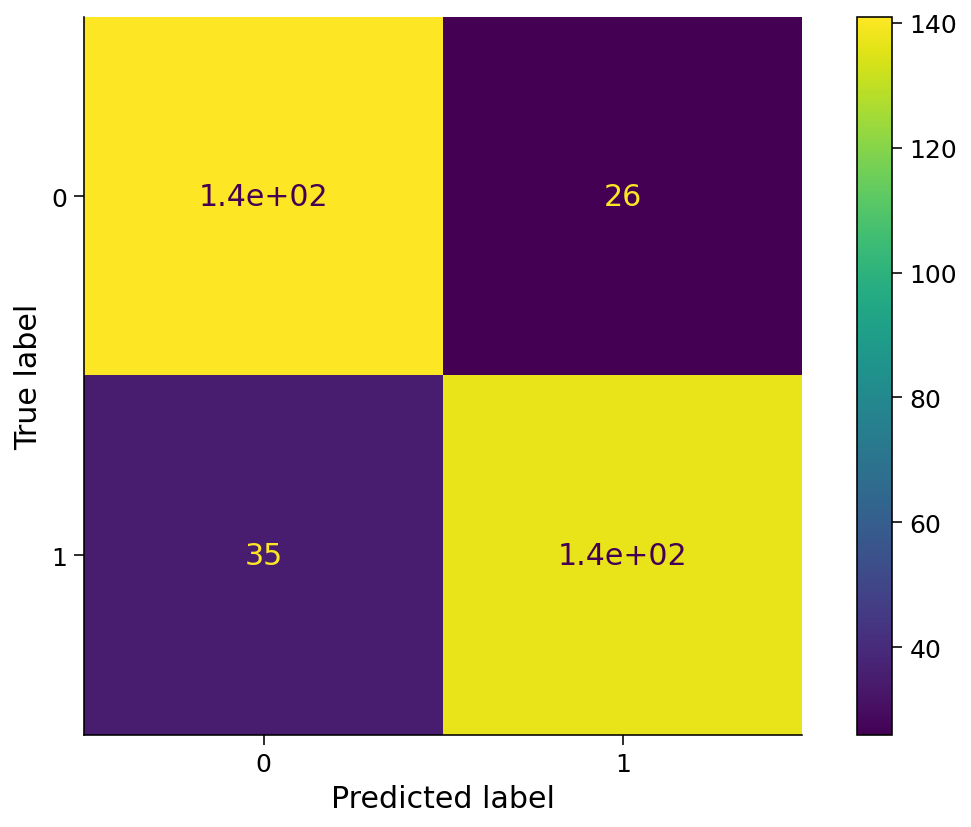

In [59]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix( lr , x_test , y_test) 

## Second let's create a model based on our highest weighted parcels

### 1-  based on our highest 20 weighted parcels

In [60]:
# taking the highest weighted parcels by the model
lr_coef= pd.DataFrame( lr.coef_ ).sort_values(  0 ,axis=1,  ascending=False ).iloc[:,:20]
lr_coef

54       90        271  ...       350       337       20 
0  0.016246  0.01597  0.015638  ...  0.010333  0.010236  0.010011

[1 rows x 20 columns]

In [61]:
lr_coef.columns.values

array([ 54,  90, 271, 250, 198, 165, 254,   4, 110,  77, 340,  12, 261,
       245, 270, 234, 113, 350, 337,  20])

In [64]:
x_coef= X[lr_coef.columns.values]
x_coef.head()

54         90         271  ...        350        337        20 
0  -9.257366   9.900445 -28.856817  ...  -5.866271  21.595368  23.605908
1  -1.634937  -3.674715  -1.818390  ...   1.131220  -0.583625   9.563350
2 -14.788816   7.695812   0.782681  ...  -6.015810   6.711635   5.432138
3  -9.155582 -15.181707  -7.364269  ... -23.188583   3.861615  -1.636333
4  -7.091152   5.720950  10.135489  ...   6.800827   7.219692  15.486838

[5 rows x 20 columns]

In [65]:
xc_train , xc_test , yc_train , yc_test = train_test_split( x_coef , y )

In [66]:
lr_c= LogisticRegressionCV( 1 ,cv= 20)
lr_c.fit(xc_train , yc_train)
lr_c.score(xc_test , yc_test )

0.5929203539823009

In [67]:
rf_c= RandomForestClassifier()
rf_c.fit(xc_train , yc_train)
rf_c.score(xc_test , yc_test ) 

0.6253687315634219

### The highest score was for the ridge model with 20 cross-validation *0.613*

In [68]:
rc_c= RidgeClassifierCV( cv= 20)
rc_c.fit(xc_train , yc_train)
rc_c.score(xc_test , yc_test )

0.5899705014749262

### 2-  the same analysis but using the highest/lowest 10 weights of the model

In [69]:
idxs= pd.concat([pd.DataFrame( lr.coef_ ).sort_values(  0 ,axis=1,  ascending=False ).iloc[:,:10] ,  pd.DataFrame( lr.coef_ ).sort_values(  0 ,axis=1,  ascending=True ).iloc[:,:10]] , axis=1).columns.values
#idxs


In [70]:
#X[idxs].head()

In [71]:
xroi_train , xroi_test , yroi_train , yroi_test = train_test_split(X[idxs] , y)

In [72]:
lrroi= LogisticRegressionCV( cv= 20)
lrroi.fit(xroi_train , yroi_train)
lrroi.score(xroi_test , yroi_test )

0.7345132743362832

In [73]:
rfroi= RandomForestClassifier()
rfroi.fit(xroi_train , yroi_train)
rfroi.score(xroi_test , yroi_test )

0.6902654867256637

### The highest score was for the ridge model with 20 cross-validation *0.71*

In [76]:
# score of the rigde classifier model with CV= 20
rcroi= RidgeClassifierCV( cv= 20 )
rcroi.fit(xroi_train , yroi_train)
rcroi.score(xroi_test , yroi_test )

0.7374631268436578

In [77]:
plot_confusion_matrix( rcroi, xroi_test , yroi_test) 

## Finally doing the same analysis using only the Highest/Lowest mean activity of the parcels, NOT INCLUDING WEIGHT

In [78]:
X_roi= loss_event_df[roi].append( win_event_df[roi])

In [79]:
X_roi.head()

201        290        186  ...        91         267        87 
0  40.136659   9.775447  27.520190  ...   1.101676 -19.821585  -9.901992
1  13.642897   2.826454 -16.771592  ...  38.721265 -10.942648 -18.616753
2  -0.807980  18.486324   8.416448  ...  -1.923900   2.302124  -3.715262
3   1.979137 -13.250361   9.161107  ... -14.866539 -12.961327  -4.715199
4  26.511429  38.809170  35.792959  ...   7.490673  -1.180152  -4.951294

[5 rows x 20 columns]

In [80]:
x_roi_train , x_roi_test , y_roi_train , y_roi_test = train_test_split(X_roi , y)

In [81]:
lr_roi= LogisticRegressionCV( cv= 20) 
lr_roi.fit(x_roi_train , y_roi_train)
lr_roi.score(x_roi_test , y_roi_test ) 

0.7256637168141593

In [82]:
rf_roi= RandomForestClassifier()
rf_roi.fit(x_roi_train , y_roi_train)
rf_roi.score(x_roi_test , y_roi_test )

0.7286135693215339

### The highest score was for the ridge model with 20 cross-validation *0.76*

In [83]:
# score of the rigde classifier model with CV= 20
rc_roi= RidgeClassifierCV( cv= 20)
rc_roi.fit(x_roi_train , y_roi_train)
rc_roi.score(x_roi_test , y_roi_test )

0.7227138643067846

Confusion matrix for the Ridge Classifier model

In [84]:
plot_confusion_matrix( rc_roi, x_roi_test , y_roi_test) 

In [85]:
#pd.DataFrame( rc_roi.coef_ )

The highest weight for parcel

In [86]:
#np.argmax( rc_roi.coef_ )

The region of the highest weight

In [87]:
regions_df.iloc[:,np.argmax( lr_roi.coef_ )]

0      R_V3A
1    Visual2
2    2.10431
Name: 12, dtype: object

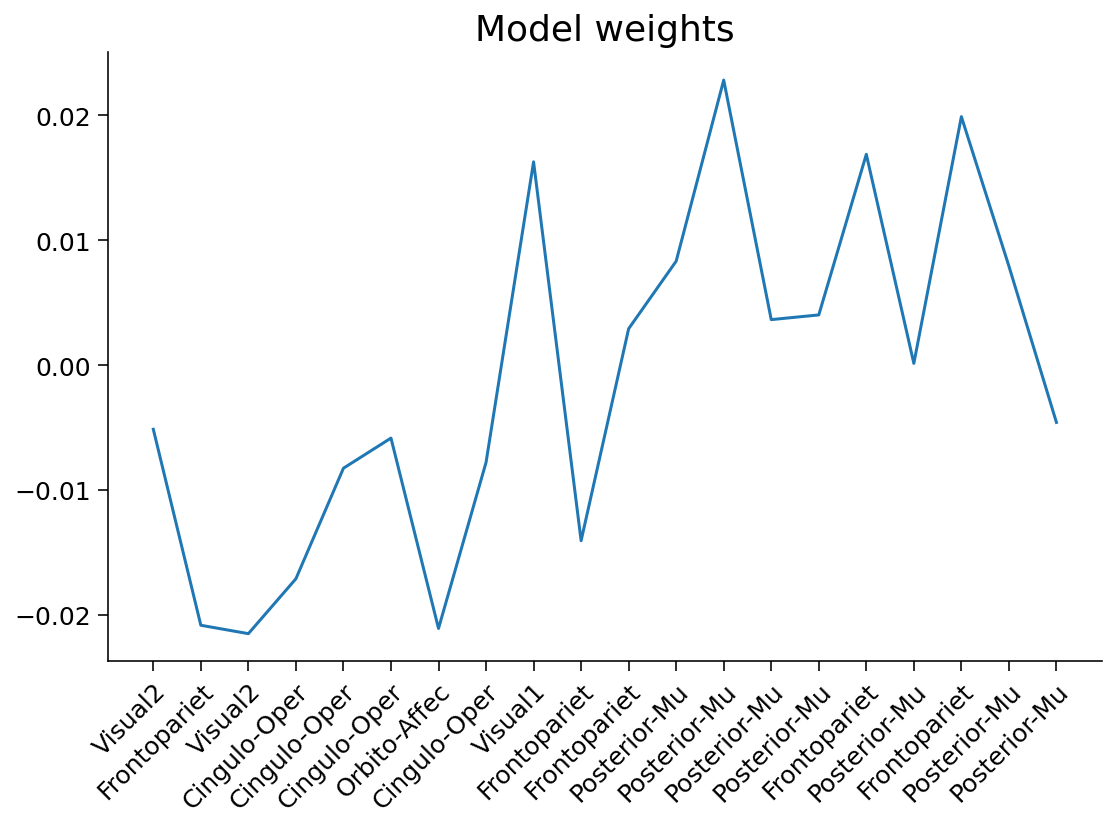

In [114]:
fig,ax=plt.subplots()
ax.plot( range(20) , lr_roi.coef_[0]  )

ax.set_xticklabels( roi_regions.iloc[1,:].to_numpy() )
ax.set_xticks(np.arange(20))

ax.set_title('Model weights')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

#### To conclude we can see that the best predictive parcels are the ones we chose via analytical solving, which gave us accuracy of 0.76 using Ridge Classifier
#### the highest/lowest 10 mean-activation parcels activity
#### And we can see that using the whole parcels with a Logistic Regression model with 20 cross-validation, will give us 0.82 accuracy, which is higher than our chosen 20 parcels by 6% only

# The plotting

In [100]:
plotting.view_connectome(cor_win, atlas["coords"], edge_threshold="80%", )

In [99]:
plotting.view_connectome(cor_loss , atlas["coords"], edge_threshold="80%")

hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot group-averaged contrast value across regions:

Plot the regional values on the surface of one hemisphere:

In [90]:
atlas["labels_L"][roi]

array([285, 318, 328, 187, 265, 329, 207, 311, 233, 201, 352, 233, 223,
       315, 328, 203, 223, 180, 350, 183], dtype=int32)

In [91]:
cor_loss.head(3)

0         1         2   ...        17        18        19
0  1.000000  0.268824  0.614975  ...  0.045099  0.037024 -0.002480
1  0.268824  1.000000  0.276281  ...  0.510033  0.555419  0.556792
2  0.614975  0.276281  1.000000  ...  0.109780  0.114141  0.074417

[3 rows x 20 columns]

In [92]:
loss_event_df[roi].columns.values

array([201, 290, 186, 107, 178, 287, 291, 85, 0, 88, 271, 164, 245, 344,
       64, 270, 244, 91, 267, 87], dtype=object)

In [93]:
cor_loss.columns= loss_event_df[roi].columns.values

In [94]:
cor_loss.head(3)

201       290       186  ...       91        267       87 
0  1.000000  0.268824  0.614975  ...  0.045099  0.037024 -0.002480
1  0.268824  1.000000  0.276281  ...  0.510033  0.555419  0.556792
2  0.614975  0.276281  1.000000  ...  0.109780  0.114141  0.074417

[3 rows x 20 columns]

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

In [95]:
# conditions = ["loss", "win"]
# # Get unique network labels
# network_names = np.unique(region_info["network"])

# hemi_networks = np.split(region_info["network"], 2)
# hemi_contrasts = np.split(group_contrast, 2)

# # Get and plot mean contrast value per network, by hemisphere
# for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
#   network_vals = []
#   for network in network_names:
#     network_vals.append(hemi_contrast[hemi_network == network].mean())
#   plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

# plt.axvline(0)
# plt.xlabel("Amplitude difference")
# plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
# plt.legend()
# plt.show()